# Differentiable 2D Rendering in JAX

In [1]:
import jax
import jax.numpy as np
import os
os.environ["CHALK_JAX"] = "1"
from chalk import *
from colour import Color
from IPython.display import display, HTML, SVG, Video, display, Image
import jax
import optax
import chalk.transform
import numpy as onp
import glob
import matplotlib.pyplot as plt
from functools import partial

chalk.transform.set_jax_mode(False)
eps = 1e-3

HTML("""
<script src="https://unpkg.com/freezeframe/dist/freezeframe.min.js"></script>
""")

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
import imageio.v2 as imageio
import base64
ff_id = 0

def animate_out(images, steps=36, rate=20, **kwargs):
    global ff_id
    with imageio.get_writer("/tmp/out.gif", loop=0, fps=rate, **kwargs) as writer:
        for im in images:
            image = imageio.imread(im)
            writer.append_data(image)
    base = base64.b64encode(open("/tmp/out.gif", 'br').read()).decode('ascii')
    ff_id += 1
    return HTML(f"""
  <img src="data:image/gif;base64,{base}" id='ff{ff_id}'>
<script>
new Freezeframe({{
  selector: '#ff{ff_id}'  
}});
</script>

<style>
  .ff-container.ff-responsive: width: 60%;
</style>

  """)

grid = rectangle(4, 4).fill_color("white").line_width(0) + (make_path([(-2, 0), (2,0)]) +  make_path([(0, -2), (0,2)])).line_color("grey").line_width(1)
hgrid = rectangle(10, 10).fill_color("white").line_width(0).align_tl()
bgrid = rectangle(100, 100).fill_color("white").line_width(0).align_tl()

def animate(fn, steps=36, rate=20, grid=grid, **kwargs):
    os.system("rm /tmp/render*.png /tmp/out.mp4 out.mp4 2> /dev/null")
    images = []
    for t in range(1, steps):
        p = f"/tmp/render.{t:03d}.jpg"
        out = fn(t)
        if chalk.transform.JAX_MODE:
            out = jax.tree.map(onp.asarray, out)
            chalk.transform.set_jax_mode(False)
            (grid + out.line_width(2).with_envelope(empty())).render(p, 500)
            chalk.transform.set_jax_mode(True)
        else:
            (grid + out.line_width(2).with_envelope(empty())).render(p, 500)
        #(grid + fn(t).line_width(2).with_envelope(empty())).render_svg(f"/tmp/render.{t:03d}.svg", 400)
        images.append(p)
    return animate_out(images)

def animate_jax(fn, steps=36, rate=20, **kwargs):
    os.system("rm /tmp/render*.png /tmp/out.mp4 out.mp4 2> /dev/null")
    images = []
    def ani(t):
        return fn(t).with_envelope(empty()).line_width(1).flatten()
    for t, d in enumerate(jax.vmap(ani)(np.arange(1, steps))):
        p = f"/tmp/render.{t:03d}.jpg"
        (grid + d.with_envelope(empty())).render(p, 500)
        #(grid + fn(t).line_width(2).with_envelope(empty())).render_svg(f"/tmp/render.{t:03d}.svg", 400)
        images.append(p)
    return animate_out(images)

In [3]:
T = 36
line = seg(V2(1, 1)).stroke()


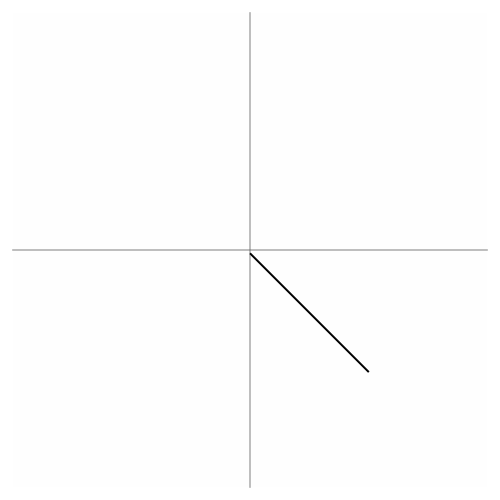

In [4]:
def translate(t):
    affine = tx.translation(V2(0, t / T))
    return line.apply_transform(affine)

animate(translate)


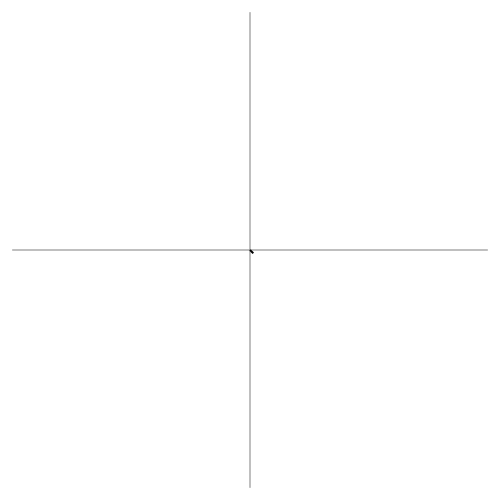

In [5]:
def scale(t):
    affine = tx.scale(t / T)
    return line.apply_transform(affine)

animate(scale)


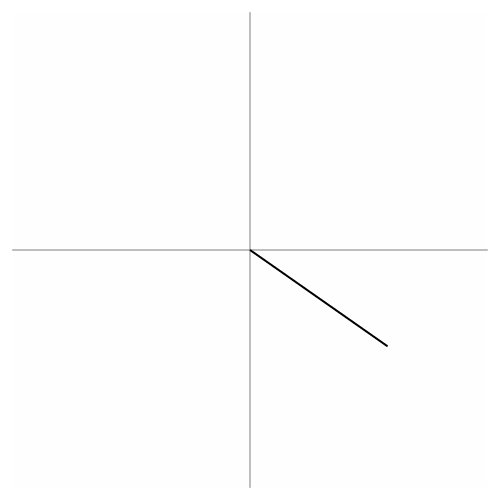

In [6]:
def rotate(t):
    affine = tx.rotation((t/ T) * 2 * np.pi)
    return line.apply_transform(affine)
animate(rotate)


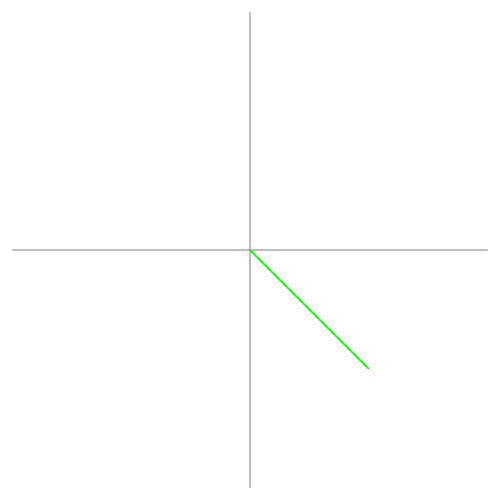

In [7]:
def color_line(t):
    r = np.array([t / T, 0, 0])
    g = np.array([0, (T -t)/ T, 0])
    return line.line_color(r + g)
animate(color_line)


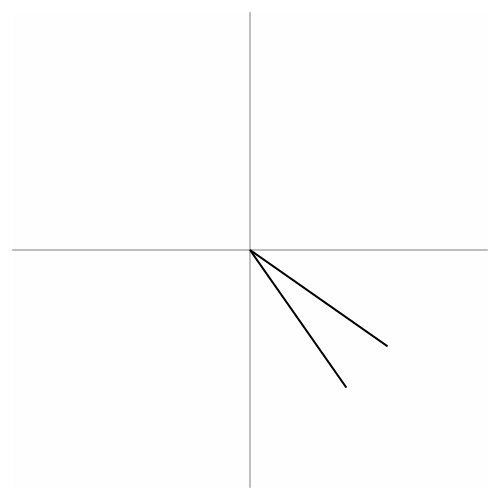

In [8]:
def cat(t):
    affine = tx.rotation((t/ T) * 2 * np.pi)
    affine2 = tx.inv(affine)
    return line.apply_transform(affine) + line.apply_transform(affine2)


animate(cat)


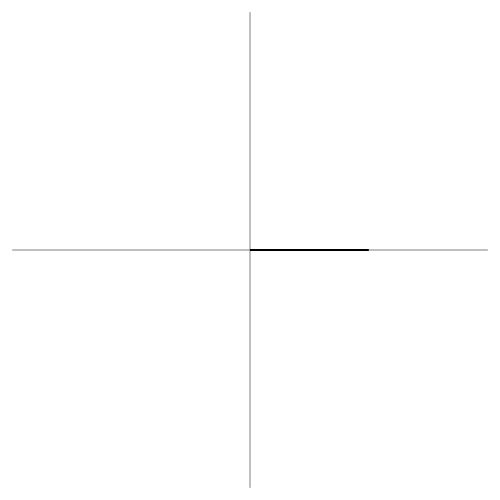

In [9]:
def arc(t):
    v = V2(1, 0)
    return arc_seg(v, t / T).stroke()
    
    
animate(arc)


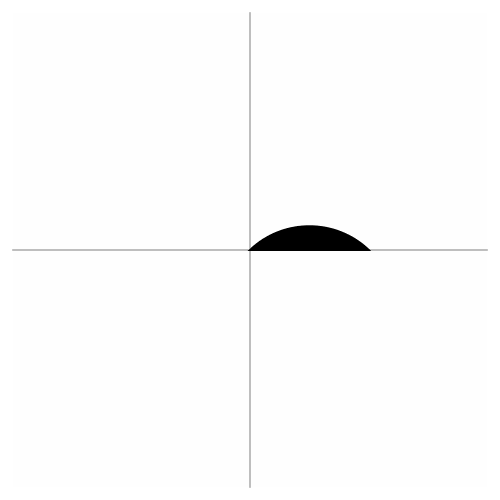

In [10]:
def closed(t):
    v = V2(1, 0)
    return (arc_seg(v, t/ T) + arc_seg(-v, -0.2) ).close().stroke()
    
animate(closed)


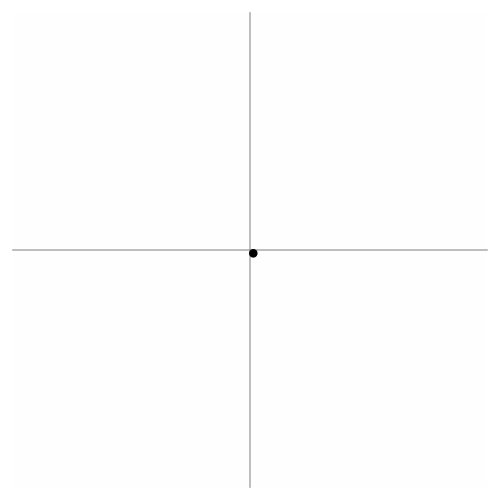

In [11]:
    
def circle_at(p, s):
    circle = (arc_seg(V2(0, 2), 1) + arc_seg(V2(0, -2), 1)).close().stroke()
    return circle.apply_transform(tx.translation(p) @ tx.scale(s) @ tx.translation(V2(0, -1)))

def circle(t):
    return circle_at(t/T, t/T)
animate(circle)


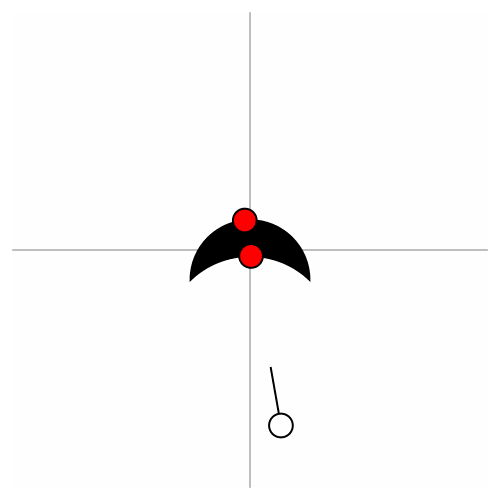

In [12]:
def crescent():
    part1 = arc_seg(unit_x, 0.5)
    part2 = arc_seg(-unit_x, -0.2)
    return part1, part2, (part1 + part2).close().stroke()
    
def trace(d, t, px=0, py=0):
    d = d.center_xy()
    # Outer satelite
    affine = tx.rotation((t/ T) * 2 * np.pi)
    pt, v = P2(0, 1.5),  V2(0, -1.5)
    pt, v = affine @ pt + V2(px, py), affine @ v

    # Trace the image
    trace = d.get_trace()
    p, m = trace(pt, v)
    
    # print.
    line = seg(V2(0, -1/2)).stroke()
    out = d + line.apply_transform(tx.translation(pt) @ affine) + circle_at(pt, 0.1).fill_color("white") 
    for i in range(p.shape[1]):
        if m[:, i]:
            out = out + circle_at(p[:, i] * v + pt, 0.1).fill_color("red")
    return out
animate(partial(trace, crescent()[2]))

How does this work?


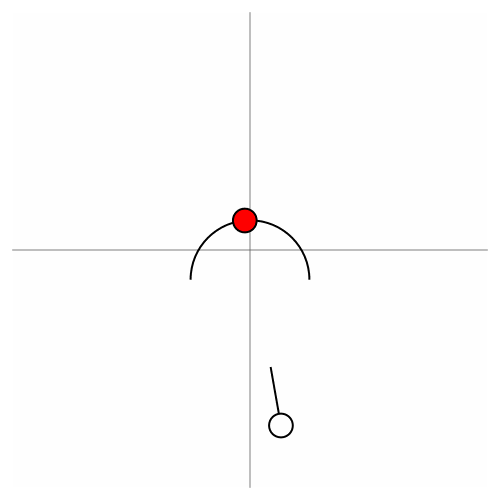

In [13]:
animate(partial(trace, crescent()[0].stroke()))


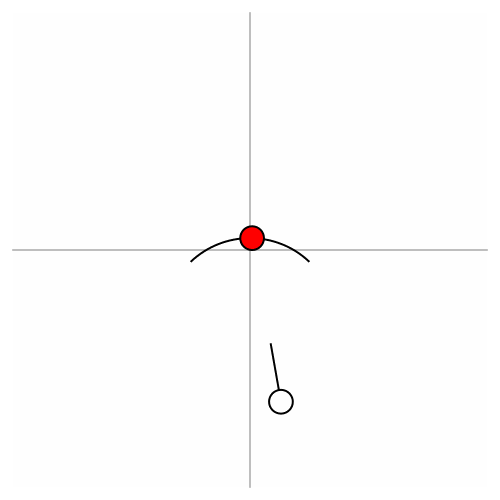

In [14]:
animate(partial(trace, crescent()[1].stroke(), py=-0.2))

Overlap at the origin

Signature: solver.init(params)
Docstring: <no docstring>
File:      ~/Projects/chalk/.venv12/lib/python3.12/site-packages/optax/_src/combine.py
Type:      function

In [241]:
def opt(x, fn, steps=100, verbose=False, save_every=1, rate=0.3):
    res = []
    fn = jax.jit(jax.value_and_grad(fn, has_aux=True))
    solver = optax.adam(learning_rate=rate)
    opt_state = solver.init(x)
    loss = []
    os.system("rm /tmp/test*.png 2> /dev/null")
    for j in range(steps):
        chalk.transform.set_jax_mode(True)
        if verbose and j == 0: print("Compiling")
        value, grad = fn(x)
        if verbose and j == 0: print("Done")

        score, out = value
        loss.append(score)
        out, h, w = out
        updates, opt_state = solver.update(grad, opt_state, x)
        x = optax.apply_updates(x, updates)
        if j % save_every == 0:
            out = jax.tree.map(onp.asarray, out)
            chalk.transform.set_jax_mode(False)
            #chalk.backend.svg.prims_to_file(out, f"test.{j:03d}.svg", h, w)
            if verbose and j == 0: print("first render")
            chalk.backend.cairo.prims_to_file(out, f"/tmp/test.{j:03d}.png", h, w)
            chalk.transform.set_jax_mode(True)
            if verbose and j == 0: print("done first render")

        if verbose:
            print(x)
    plt.plot(loss)
    images= sorted(glob.glob("/tmp/test.*.png"))
    return animate_out(images)

In [20]:
def render_trace(d, pt, v):
    # Trace the image
    trace = d.get_trace()
    p, m = trace(pt, v)
    
    line = seg(V2(0, -1/2)).stroke()
    out = d +  seg(v).stroke().translate_by(pt) + circle_at(pt, 0.1).fill_color("white")
    score = p[:, 1] - p[:, 0] 
    pos = (1-m[:, :])[..., None, None] * 100 + p[..., None, None] * v + pt

    out = out + Path.from_points([pos[:, 0], pos[:, 1] + eps]).stroke().line_color("white").line_width(10)
    for i in range(2):
        out = out + circle_at(pos[:, i], 0.1).fill_color("red")
    return out, p
render_trace(crescent()[2].center_xy(), P2(1, 1), V2(-1, -1))[0]

rm: cannot remove '/tmp/test*.png': No such file or directory



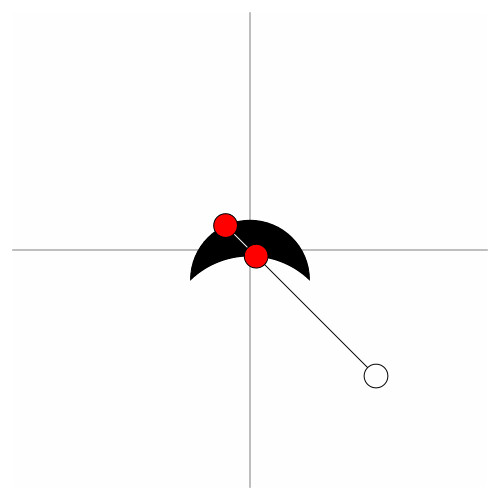

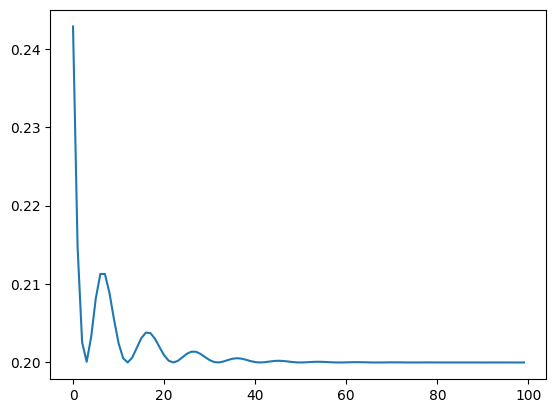

In [21]:
def trace(d, t, px=0, py=0):
    d = d.center_xy()
    # Outer satelite
    affine = tx.rotation(t)
    pt, v = P2(0, 1.5),  V2(0, -1.5)
    pt, v = affine @ pt + V2(px, py), affine @ v

    # Trace the image
    out, p = render_trace(d, pt, v)
    score = p[:, 1] - p[:, 0]
    return score.sum(), chalk.core.layout_primitives(grid + out.line_width(1), 500)


chalk.transform.set_jax_mode(True)
opt(np.array(np.pi / 4.), partial(trace, crescent()[2]))

In [22]:
chalk.transform.set_jax_mode(True)

def draw(i):
    return circle_at(P2(0, i), 1.0)
jax.vmap(draw)(np.arange(1, 5))

In [23]:
def draw(i):
    x, y = i // 4, i % 4
    return circle_at(i, 1)
grid  + jax.vmap(draw)(np.arange(10))



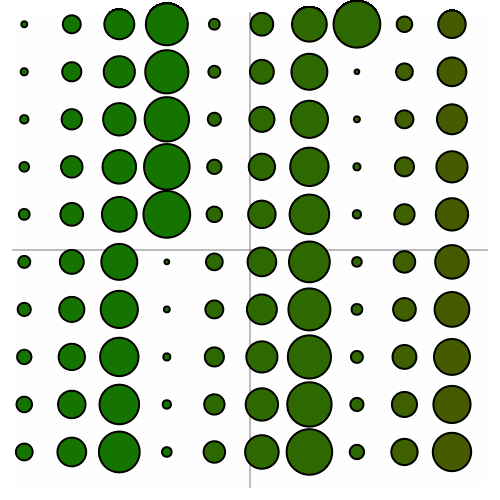

In [24]:
chalk.transform.set_jax_mode(True)

r = chalk.style.to_color("red")
g = chalk.style.to_color("green")

def multi(t):
    def draw(i):
        x, y = i // 10, i % 10
        c = lambda i: ((t + i) % T /T)
        return circle_at(P2(4 *x / 10, 4*y/10) - P2(1.9, 1.9), 2 * c(i) / 11 + 0.02).fill_color(c(x) * r + (1 - c(x))*g)
    return jax.vmap(draw)(np.arange(100))

animate(jax.jit(multi))


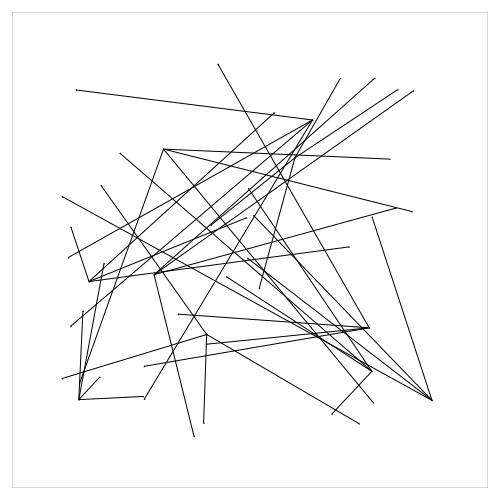

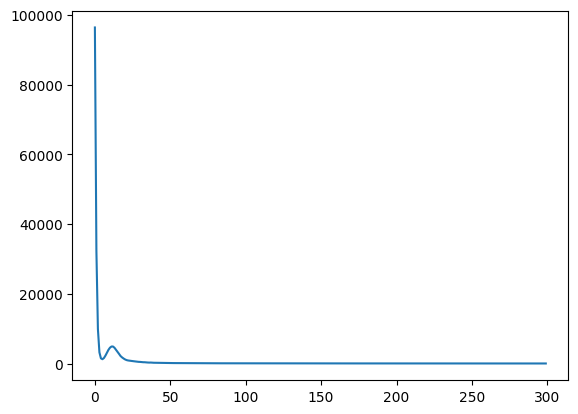

In [25]:

size = 50
around = 5
color = np.stack([chalk.style.to_color(c) 
                  for c in  Color("red").range_to("blue", size // around)],
                 axis=0)

matrix = jax.random.uniform(jax.random.PRNGKey(0), (size, 2)) * 4 - 2
edges = np.stack([np.minimum(size, np.ones((size,), int) + around * (np.arange(size) // around)) 
                  ], axis=1)

@jax.jit
def graph(x):
    # Draw nodes
    def dots(p, i):
        return circle(0.1).translate(p[0], p[1]).fill_color(color[i // around] * np.maximum((i % around) / (around - 1), 0.5))
    
    out = jax.vmap(dots)(x, np.arange(size)).with_envelope(empty()).line_width(1)    

    # draw edges
    def connect(p):
        eps = 1e-4
        return make_path([(p[0, 0], p[0, 1]), 
                        (p[1, 0]+ eps, p[1, 1] + eps)])
        
    a, b = x[:, None, :], x[edges]
    v = np.stack([a, b], axis=-2).reshape((-1, 2, 2))
    lines = jax.vmap(connect)(v).with_envelope(empty())

    # Loss function 
    center =  1/10 * np.abs(x).sum()
    repulse = (1/ size) * ((1 / (1e-3 + np.pow(x[:, None, :] - x, 2).sum(-1))) * (1 -np.eye(size))).sum()
    spring = size * np.pow(np.pow(v[:, 1] - v[:, 0], 2).sum(-1) - 0.04, 2).sum()
    score = spring + center + repulse
    
    
    out = lines.line_width(1) + out
    out = rectangle(5, 5).fill_color("white")  + out
    return score, chalk.core.layout_primitives(out, 500)

opt(matrix, graph, steps=300)


# Rendering


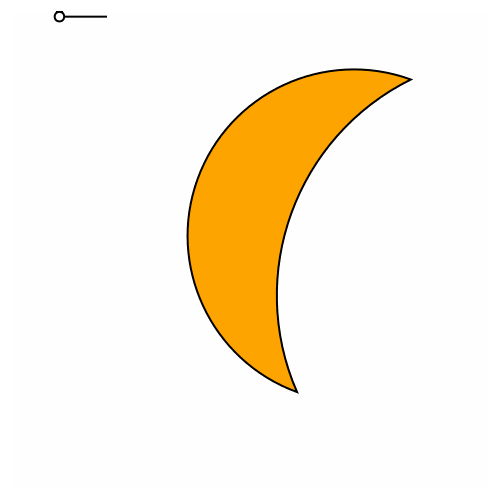

In [28]:
shape = crescent()[2].scale(7).rotate(70).translate(6, 8).fill_color("orange")
def scan(t):
    return render_trace(shape, P2(1, 10 * t/ 100), V2(1, 0))[0]

animate(scan, grid=hgrid, steps = 100)

In [70]:
?jax.lax.scan

Signature:
jax.lax.scan(
    f: 'Callable[[Carry, X], tuple[Carry, Y]]',
    init: 'Carry',
    xs: 'X | None' = None,
    length: 'int | None' = None,
    reverse: 'bool' = False,
    unroll: 'int | bool' = 1,
    _split_transpose: 'bool' = False,
) -> 'tuple[Carry, Y]'
Docstring:
Scan a function over leading array axes while carrying along state.

The `Haskell-like type signature`_ in brief is

.. code-block:: haskell

  scan :: (c -> a -> (c, b)) -> c -> [a] -> (c, [b])

where for any array type specifier ``t``, ``[t]`` represents the type with an additional
leading axis, and if ``t`` is a pytree (container) type with array leaves then ``[t]``
represents the type with the same pytree structure and corresponding leaves
each with an additional leading axis.

When the type of ``xs`` (denoted `a` above) is an array type or None, and the type
of ``ys`` (denoted `b` above) is an array type, the semantics of :func:`~scan` are
given roughly by this Python implementation::

  def scan(f, ini


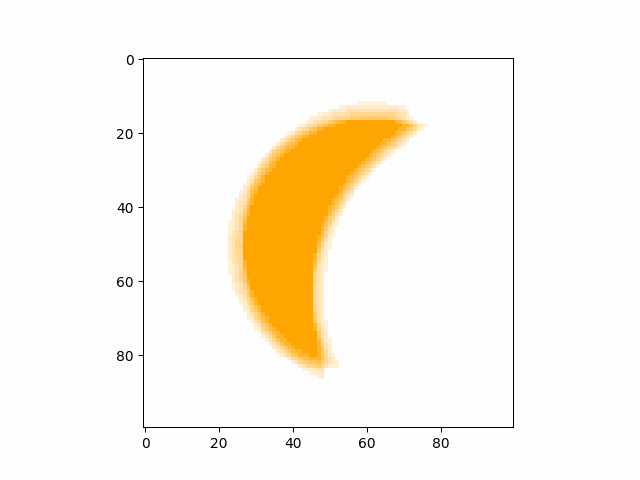

<Figure size 640x480 with 0 Axes>

In [584]:
SIZE = 100
blank = np.ones((SIZE, SIZE, 3))
directions = list(map(np.stack, [
                (V2(0, 1), V2(1, 0)), 
               (V2(1, 0), V2(0, 1)),
               (0, 1)]))


kern = 11
samples = np.arange(kern) - (kern//2)
def kernel(offset):
    off_samples = samples - offset
    gaussian_kernel = kern - np.abs(off_samples)
    return np.maximum(0, gaussian_kernel / (kern - np.abs(samples)).sum())
    
@jax.jit
def render_line(splits, mask):
    mask = mask & (splits > 2.)
    split_int = np.floor(splits).astype(int)
    splits, ind = splits, np.where(mask, split_int, 1000)
    scene = np.zeros(SIZE)
    loc = np.arange(splits.shape[-1]) % 2
    inout = np.where(loc, -1, 1)
    scene = scene.at[ind].add(inout).at[0].set(0)
    scene = np.cumsum(scene, axis=-1)
    
    return np.where(mask.sum() % 2 ==0, 
            scene.at[ind].set(np.where(loc, 0, 1) - inout * (splits - split_int)).at[0].set(0),
           np.zeros(SIZE))

@jax.jit
def render_shape(img, s):
    k = kernel(0)
    S = np.arange(SIZE)
    #for pt, v, axis in directions:
    def render(img, d):
        pt, v, axis = d
        raster = jax.vmap(lambda i: render_line(*s.get_trace()(tx.to_point(pt * i) , v)))(S)
        # Apply a 1d conv
        raster = jax.vmap(lambda scene: jax.vmap(lambda s: scene[s + samples] @ k)(S))(raster)
        img = (1 - raster[..., None]) * img + raster[..., None] * s.style.fill_color_
        return np.swapaxes(img, 0, 1), raster
    img = jax.lax.scan(render, img, directions)
    return img[0], img[1]
os.system("rm /tmp/test*.png")

chalk.transform.set_jax_mode(True)
def im(t):
    s = shape.center_xy().scale(10).rotate_by(t / T).translate(50, 50)
    img = render_shape(blank, s)[0]
    plt.imshow(img)
    plt.savefig(f"/tmp/test.{t:02d}.png")
    plt.clf()
for i in range(T):
    im(i)
animate_out(sorted(glob.glob("/tmp/test.*.png")))


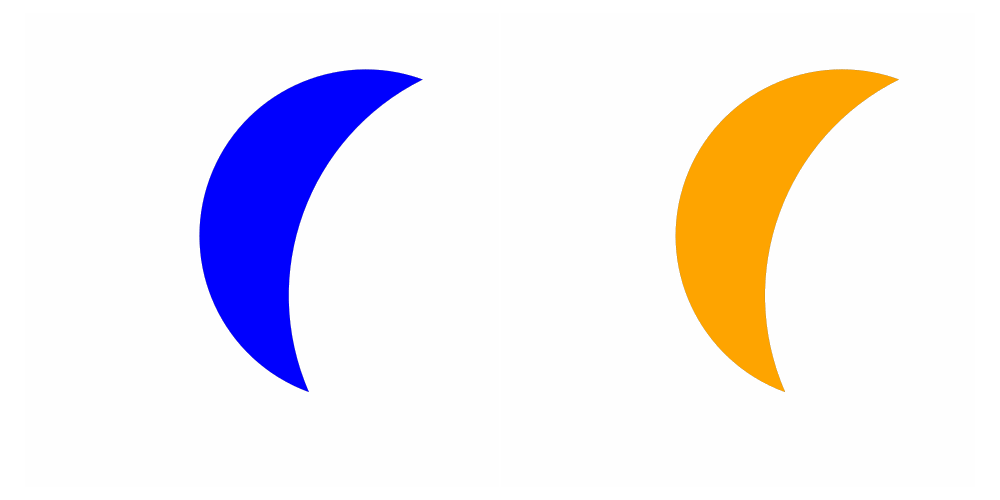

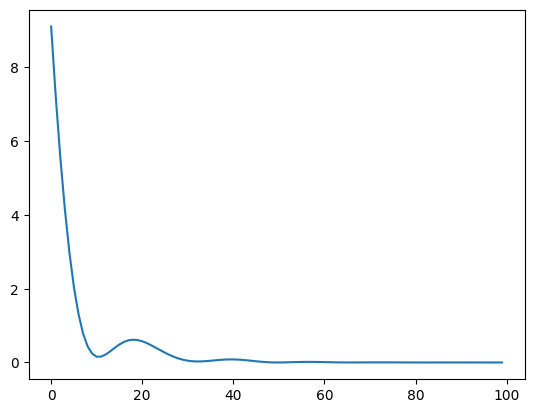

In [577]:
goal = render_shape(blank, shape)[0]

def make_shape(color):
    return shape.fill_color(color)

def loss(x):
    y = render_shape(blank, x)[0]
    return np.pow(y - goal, 2).sum(), chalk.core.layout_primitives((hgrid + x) | (hgrid + shape), 500)

opt(chalk.style.to_color("blue"), lambda x: loss(make_shape(x)), rate=0.1)

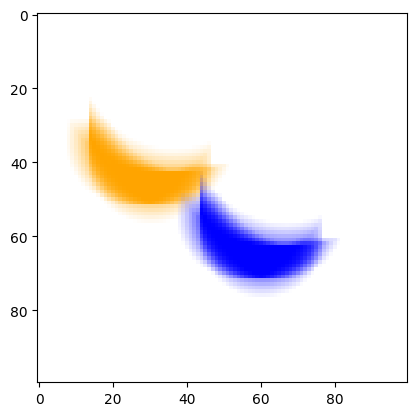

In [585]:
@jax.vmap
def make_shape1(p):
    #s = rectangle(31, 31).rotate(1).translate(params[0], params[1]).fill_color("green")
    loc, color = p
    return shape.center_xy().rotate_by(1/4).scale(5).translate(loc[0], loc[1]).fill_color(color)
   
def render_shapes(shapes):
    return jax.lax.scan(render_shape, blank, shapes)[0]
    
start_param = (np.array([[30, 40], [60., 60.]], np.float64), 
               np.stack([chalk.style.to_color("orange"), chalk.style.to_color("blue")]))
start = make_shape1(start_param)
plt.imshow(render_shapes(start))
#plt.imshow(render_shapes(star(g))[2, 0])


0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 2
28 2
29 2
30 2
31 2
32 2
33 2
34 2
35 2
36 2
37 2
38 2
39 2
40 2
41 2
42 2
43 2
44 2
45 2
46 2
47 2
48 2
49 2
50 2
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 0
71 0
72 0
73 0
74 0
75 0
76 0
77 0
78 0
79 0
80 0
81 0
82 0
83 0
84 0
85 0
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 0
94 0
95 0
96 0
97 0
98 0
99 0


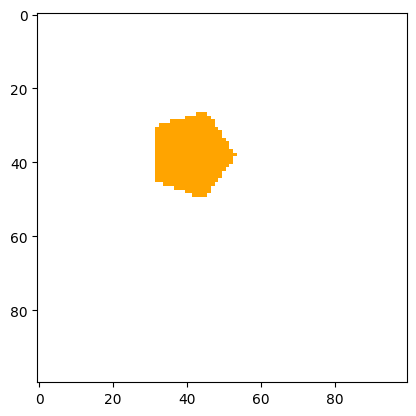

In [523]:
# t = list(star(g))[2].get_trace()
# for i in range(100):
#     s, m = t(P2(0, i), V2(1, 0))
#     print(i, m.sum())
# plt.imshow(render_shape(blank, list(star(g))[2])[0])

In [580]:

@jax.custom_vjp
def boundary(scene, splits, mask):
    return scene

def f_fwd(scene, splits, mask):
    return scene, (scene, splits, mask)

def f_bwd(res, g):
    scene, splits, mask = res
    split_int = np.floor(splits).astype(int) 
    def grad_p(s, s_off):
        off = s_off - s
        v = g[s + samples]
        return (v * (scene[s+1] - scene[s-1])).sum(-1) @ kernel(off)  
    r = jax.vmap(grad_p, in_axes=(-1, -1))(split_int, splits) * (mask & (splits > 2))
    return g, -r, None

boundary.defvjp(f_fwd, f_bwd)




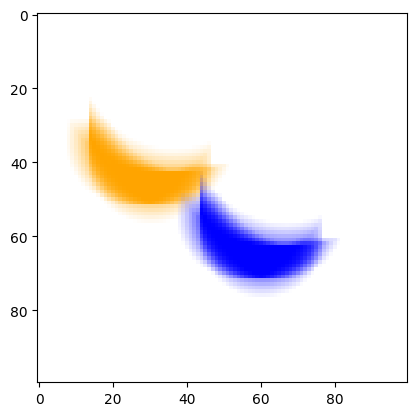

In [586]:
@jax.jit
def boundary_shape(img, s):
    S = np.arange(SIZE)
    #img2 = np.zeros(img.shape)
    trace = s.get_trace()
    def bound(img, d):
        pt, v, axis = d
        s, m = jax.vmap(lambda i: trace(tx.to_point(pt * i), v))(S)
        bound = lambda s, m: jax.vmap(lambda s, m, im: boundary(im, s, m))(s, m, img)
        img = bound(s, m)
        return np.swapaxes(img, 0, 1), None
    return jax.lax.scan(bound, img, directions)[0], None
        
    # for pt, v, axis in directions:
    #     for s in ls:
    #         trace = s.get_trace()
    #         s, m = jax.vmap(lambda i: trace(tx.to_point(pt * i), v))(S)
    #         bound = lambda s, m: jax.vmap(lambda s, m, im: boundary(im, s, m))(s, m, img)
    #         img = bound(s, m)

def boundaries(img, shapes):
    return jax.lax.scan(boundary_shape, img, shapes)[0]

            # if draw:
            #     split_int = np.floor(s).astype(int) 
            #     grad = jax.grad(lambda s, m: bound(s, m).sum())(s, m)
            #     for i in S:
            #         for p in range(grad.shape[2]):
            #             if np.abs(grad[i, :, p]) > 0 and m[i, :, p]:
            #                 img2 = img2.at[i, split_int[i, :, p ]].set(
            #                     np.where(grad[i, :, p] > 0, 
            #                             chalk.style.to_color("red") if axis == 0 else chalk.style.to_color("green"), 
            #                              chalk.style.to_color("blue")if axis == 0 else chalk.style.to_color("yellow") ))
        # img, img2 = np.swapaxes(img, 0, 1), np.swapaxes(img2, 0, 1)

    
#     return img, np.where(img2.sum(-1)[:, :, None] > 0, img2, img)
# def boundaries():
#     jax.lax.scan

img = render_shapes(start)
img = boundaries(img, start)
#r = jax.grad(lambda i, s: np.sum(boundaries(i,s )))(img, start)[1]
plt.imshow(img)

Signature: opt(x, fn, steps=100, verbose=False, save_every=1, rate=0.3)
Docstring: <no docstring>
File:      /tmp/ipykernel_660105/771973468.py
Type:      function

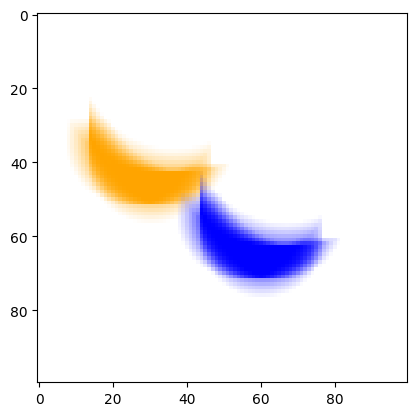

In [587]:
plt.imshow(render_shapes(make_shape1(start_param)))


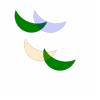

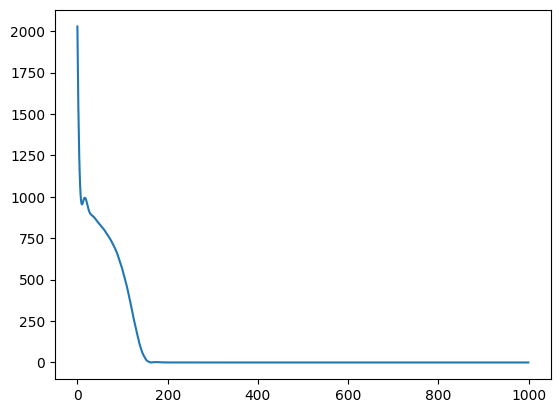

In [588]:
goal_shapes = make_shape1((np.array([[50, 20], [40, 50]]),
                           np.stack([chalk.style.to_color("blue"), chalk.style.to_color("orange")])))

goal = render_shapes(goal_shapes)
start_param = (np.array([[30, 20], [60., 60.]], np.float64), 
               np.stack([chalk.style.to_color("green"), chalk.style.to_color("green")]))

def loss(goal, goal_shapes, x):
    y = render_shapes(x)
    y = boundaries(y, x)
    return np.pow(y - goal, 2).sum(), chalk.core.layout_primitives((bgrid + concat(x).with_envelope(empty()) + concat(goal_shapes).with_envelope(empty()).fill_opacity(0.2)), 100)


opt(start_param, lambda x: loss(goal, goal_shapes, make_shape1(x)), steps=1000, save_every=5, verbose=False, rate=0.1)


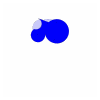

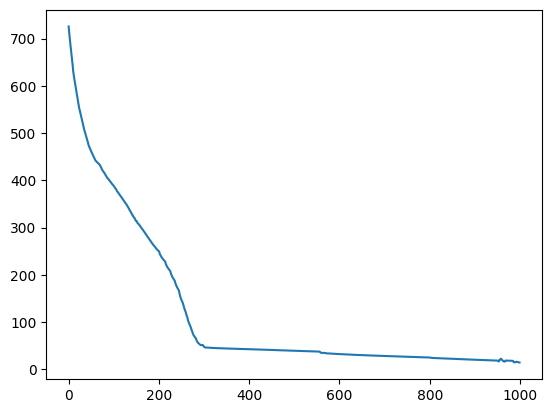

In [594]:
@jax.vmap
def make_shape2(params):
    s, l, r = params
    s = np.where(np.abs(s) < 1e-3, 1e-3, s)
    part1 = arc_seg(unit_x, s[0])
    part2 = arc_seg(unit_y, s[1])
    part3 = arc_seg(-unit_x, s[2])
    part4 = arc_seg(-unit_y, s[3])
    d= (part1 + part2 + part3 + part4).close().stroke()
    shape = d.scale(12 + r[0]).rotate(70)
    return shape.center_xy().rotate_by(0).translate( 50, 30).fill_color("blue")
    
goal_params = (
    np.array([[0.5, 0.2, 0.7, -0.9]]), 
    np.array([[50., 30]]),
    np.array([[5.]]))
goal_shapes = make_shape2(goal_params)
goal = render_shapes(goal_shapes)
start_param = (
    np.array([[-0.5, 0.1, 2, 1]]), 
    np.array([[50., 30]]),
    np.array([[0.]]))
#hgrid + make_shape2(start_param)
opt(start_param, lambda x: loss(goal, goal_shapes, make_shape2(x)), steps=1000, save_every=5, rate=0.01, verbose=False)


In [ ]:
plt.imshow(render_shapes(make_shape2(start_param)))

In [39]:
import random


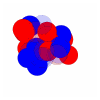

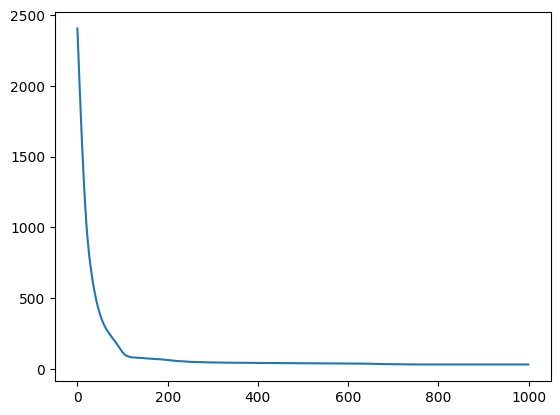

In [593]:
@jax.vmap
def make_shape3(params, i):
    #s = []
    s, l = params 
    s = np.minimum(np.maximum(s, 5.), 15)
    red, blue = chalk.style.to_color("red"), chalk.style.to_color("blue")
    return circle_at(tx.X.origin, s).translate(l[0], l[1]).fill_color(np.where(i % 2, red , blue ))

make_shape3 = partial(make_shape3, i = np.arange(10.))

goal_param = (np.array([10 + random.random() for i in range(10)]),
              np.array([20 + random.random() * 40 for i in range(20)]).reshape(10, 2)
             )
goal_shapes = make_shape3(goal_param)
#hgrid + goal_shapes

make_shape3 = partial(make_shape3, i = np.arange(20.))

goal = render_shapes(goal_shapes)
start_param = (np.array([10 + random.random() for i in range(20)]),
              np.array([20 + 50 * random.random() for i in range(40)], np.float64).reshape(20, 2))

#hgrid + _shapes
opt(start_param, lambda x: loss(goal, goal_shapes, make_shape3(x)), steps=1000, save_every=5, rate=0.1, verbose=False)


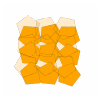

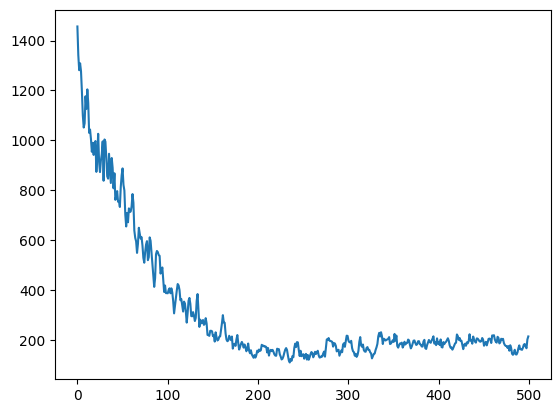

In [600]:
@jax.vmap
def star(x):
    sides = 5
    edge = Trail.hrule(1)
    return Trail.concat(
        edge.rotate_by(( i) / sides) for i in range(sides)
    ).close().stroke().center_xy().scale(15).rotate_by(x[1]).translate(25 + x[2], 25 + x[3] ).fill_color("orange")
    
start_param = np.array([[15.,random.random(),  5 + i * 20, 10 + 20 * j] for i in range(3) for j in range(3)])
g = np.array([[15., random.random(), 1 + i * 20, 1 + 20 * j] for i in range(3) for j in range(3)])
goal_shapes = star(g)
goal = render_shapes(star(g))

opt(start_param, lambda x: loss(goal, goal_shapes, star(x)), steps=500, save_every=10, rate=0.05, verbose=False)


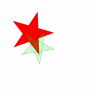

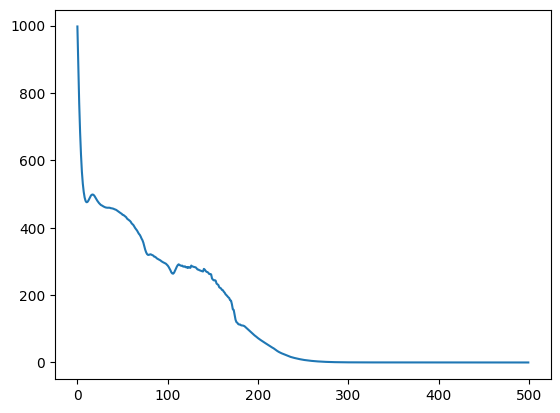

In [596]:
@jax.vmap
def star(x):
    sides = 5
    edge = Trail.hrule(1)
    return Trail.concat(
        edge.rotate_by((2 * i) / sides) for i in range(sides)
    ).close().stroke().scale(x[0]).rotate(x[1]).align_tl().translate(10 + x[2], x[3]).fill_color(x[4:7])
start_param = np.array([[45., 20,  1, 10, 1.0, 0.0, 0.0]])
g = np.array([[35., 9, 10, 30, 0.0, 1.0, 0.0]])
goal_shapes = star(g)
goal = render_shapes(star(g))

opt(start_param, lambda x: loss(goal, goal_shapes, star(x)), steps=500, save_every=10, rate=0.1, verbose=False)

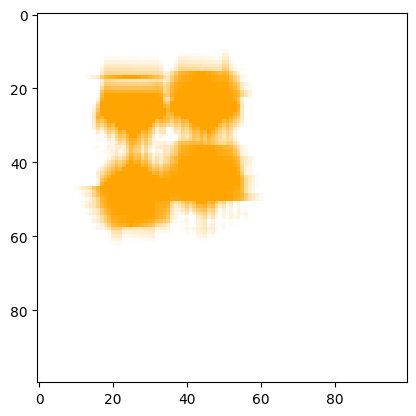

In [562]:
#plt.imshow(goal)
plt.imshow(render_shapes(star(start_param)))

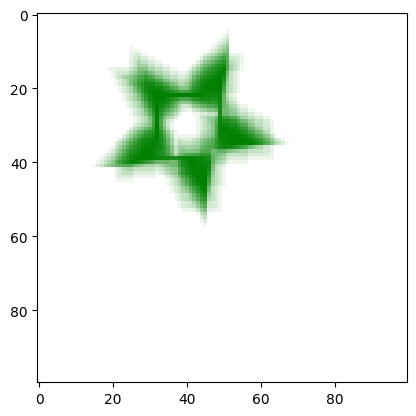

In [321]:
plt.imshow(goal)

In [ ]:
aff = tx.translation(V2(2, 3))
(aff @ z).show_origin()

In [ ]:
concat([tx.translation(V2(2* i, 3)) @ z for i in range(3)])

In [ ]:
t = seg(V2(1,0)) + seg(V2(2, 3))
t.stroke().show_origin()

In [ ]:
t = seg(V2(1,0)) + seg(V2(1, 1)) + seg(V2(-1, 0)) + seg(V2(-1, -1))
t.close().stroke()

In [ ]:
t = arc_seg(V2(1,0), 0.5).stroke()
t

In [ ]:
turn = tx.rotation(np.pi)
x = arc_seg(V2(1,0), 0.5)

circle = (x + (turn @ x)).close().stroke()

circle = (tx.translation(V2(-0.5, 0)) @ circle)
circle.show_origin()

In [ ]:
t = [arc_seg(V2(1,0), i / 5).stroke() for i in range(1, 5)] 
concat(t)

In [ ]:
p = P2(4, 5)
p

In [ ]:
def line(p1, p2):
    return tx.translation(p1) @ seg(p2 - p1).stroke()
line(P2(2, 2), P2(4, 5)).show_origin()

In [ ]:
def draw_point(p):
    return tx.translation(p) @ circle.fill_color("red")
draw_point(p).show_origin()

In [ ]:
big_circle = tx.scale(V2(5, 5)) @ circle
trace = big_circle.get_trace()
v = V2(-4, -5)
p2, m2 = trace(p, v)
big_circle + draw_point(p) + concat([draw_point(i * v+ p).fill_color("blue")
                                 for i, j in zip(p2[0], m2[0]) if j])


In [ ]:
type(circle)

In [ ]:
p_many = P2(np.arange(5), np.array([5] * 5))
draw_point(p_many).show_origin()

In [ ]:
p_many = P2(np.arange(5), np.array(5))
v_many = tx.to_vec(p_many)
p2, m2 = trace(p_many, -v_many)
colors = list(Color("blue").range_to("red", 5))
big_circle + \
    concat([(draw_point(p_many[k]) + draw_point(i * -v_many[k] + p_many[k])).fill_color(colors[k])
            for k in range(p2.shape[0])
            for i, j in zip(p2[k], m2[k]) 
            if j])